In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
import os
from matplotlib.animation import FuncAnimation
logger = logging.getLogger(__name__)


# Parameters
Lx = 10  #size of domain
Nx = 128 #no of points in mesh
Ly = 10
Ny = 128
c = 1 #the wave speed
A = 1
dealias = 3/2
stop_sim_time = 12
timestepper = d3.SBDF2
timestep = 0.01
dtype = np.float64

# Bases
xcoord = d3.Coordinate('x')
ycoord = d3.Coordinate('y')

dist = d3.Distributor([xcoord, ycoord], dtype=dtype)
xbasis = d3.RealFourier(xcoord, size=Nx, bounds=(0, Lx), dealias=dealias)
ybasis = d3.RealFourier(ycoord, size=Ny, bounds=(0, Ly), dealias=dealias)

# Fields
u = dist.Field(name='u', bases=(xbasis,ybasis))
v = dist.Field(name='v', bases=(xbasis,ybasis))

# Substitutions
dx = lambda A: d3.Differentiate(A, xcoord)
dy = lambda A: d3.Differentiate(A, ycoord)

# Problem
problem = d3.IVP([u,v], namespace=locals())
problem.add_equation("dt(u) - v = 0")
problem.add_equation("dt(v) - c**2 * (dx(dx(u)) +dy(dy(u))) = 0")

# Initial conditions
x_0 = Lx/2
y_0 = Ly/2
sigma = np.sqrt(1e-2)
x = dist.local_grid(xbasis)
y = dist.local_grid(ybasis)
XX, YY = np.meshgrid(x, y, indexing='ij')
u['g'] = A * np.exp(-((XX-x_0)**2 + (YY-y_0)**2)/(2*(sigma**2)))
v['g'] = np.zeros_like(dist.local_grid(xbasis))

# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

# Main loop
u.change_scales(1)
v.change_scales(1)
u_list = [np.copy(u['g'])]
t_list = [solver.sim_time]
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 100 == 0:
        logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
    if solver.iteration % 25 == 0:
        u.change_scales(1)
        v.change_scales(1)
        u_list.append(np.copy(u['g']))
        t_list.append(solver.sim_time)


2023-08-07 16:47:38,350 subsystems 0/1 INFO :: Building subproblem matrices 1/64 (~2%) Elapsed: 0s, Remaining: 0s, Rate: 1.6e+02/s
2023-08-07 16:47:38,369 subsystems 0/1 INFO :: Building subproblem matrices 7/64 (~11%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+02/s
2023-08-07 16:47:38,392 subsystems 0/1 INFO :: Building subproblem matrices 14/64 (~22%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+02/s
2023-08-07 16:47:38,414 subsystems 0/1 INFO :: Building subproblem matrices 21/64 (~33%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+02/s
2023-08-07 16:47:38,437 subsystems 0/1 INFO :: Building subproblem matrices 28/64 (~44%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+02/s
2023-08-07 16:47:38,459 subsystems 0/1 INFO :: Building subproblem matrices 35/64 (~55%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+02/s
2023-08-07 16:47:38,482 subsystems 0/1 INFO :: Building subproblem matrices 42/64 (~66%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+02/s
2023-08-07 16:47:38,504 subsystems 0/1 INFO :: Building subproblem matri

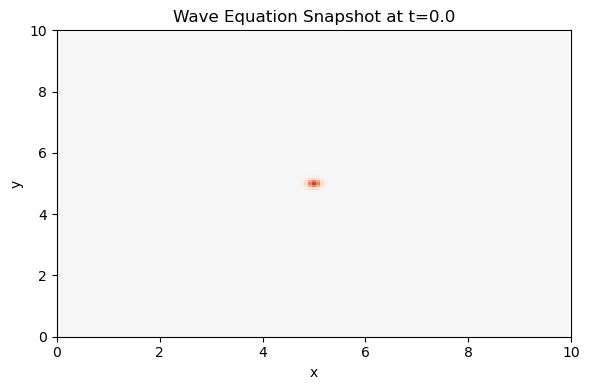

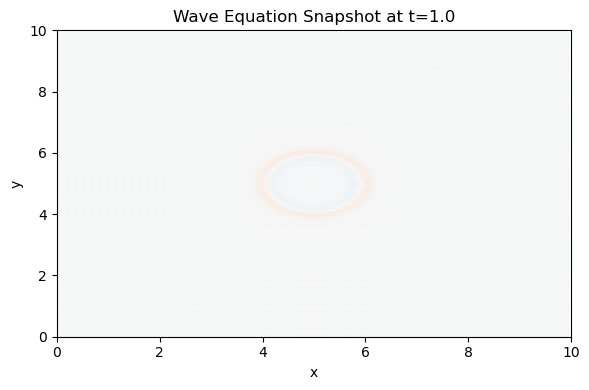

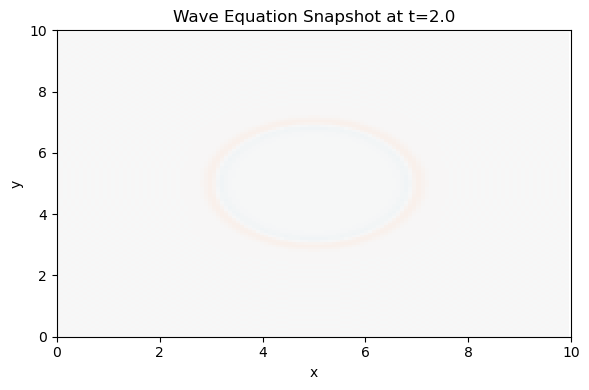

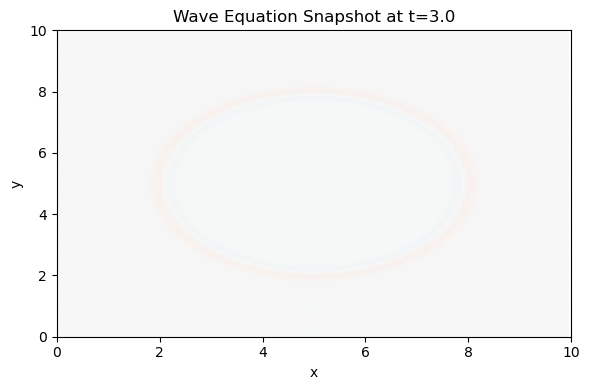

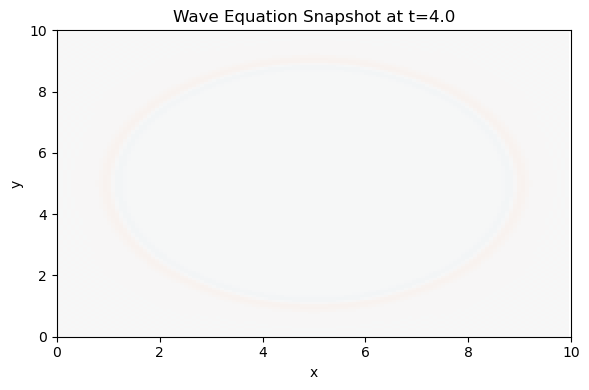

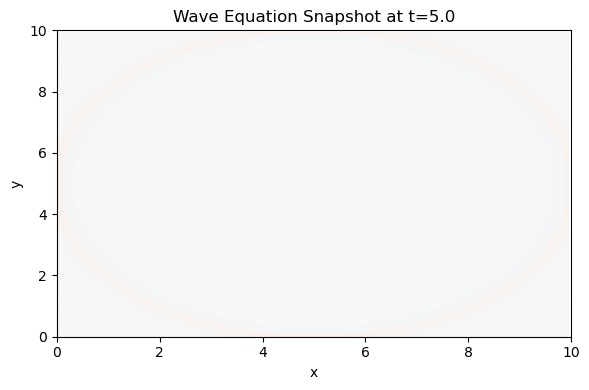

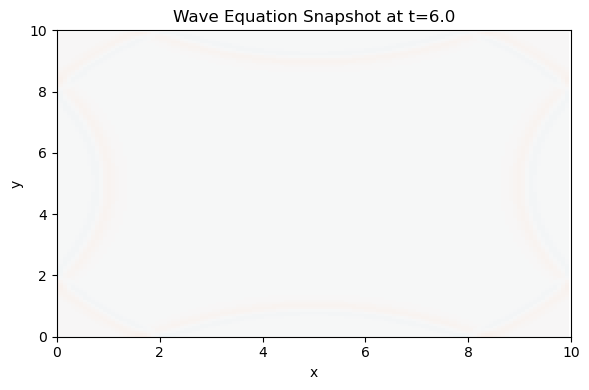

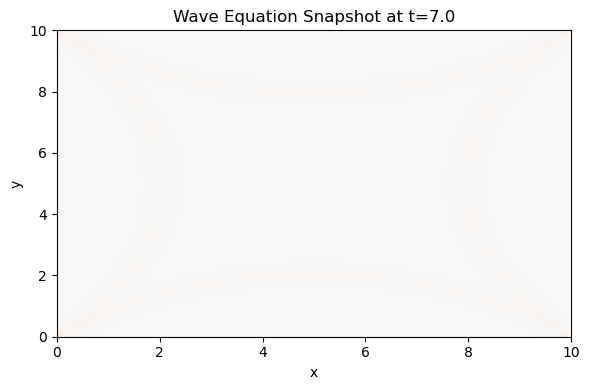

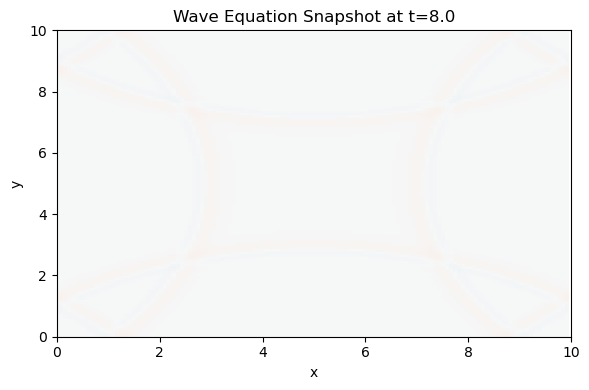

In [2]:
import math
import matplotlib.colors as mcolors

num = 10

for i in range(num):
    target_time = i  # Time value for current snapshot
    idx = min(range(len(t_list)), key=lambda j: abs(t_list[j] - target_time))
    
    norm = mcolors.Normalize(vmin=-6 * A, vmax=6 * A)

    plt.figure(figsize=(6, 4))
    
    plt.pcolormesh(x.ravel(), y.ravel(), u_list[idx].T, cmap='RdBu_r', shading='auto', rasterized=True, clim=(-1.5 * A, 1.5 * A), norm=norm)
    plt.xlim(0, Lx)
    plt.ylim(0,Ly)
  
    snapshot_time = round(t_list[idx], 2)
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Wave Equation Snapshot at t={snapshot_time}')
    plt.tight_layout()
    
plt.close()

2023-08-07 16:47:56,610 matplotlib.animation 0/1 WARNING :: MovieWriter imagemagick unavailable; using Pillow instead.
2023-08-07 16:47:56,611 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.PillowWriter'>


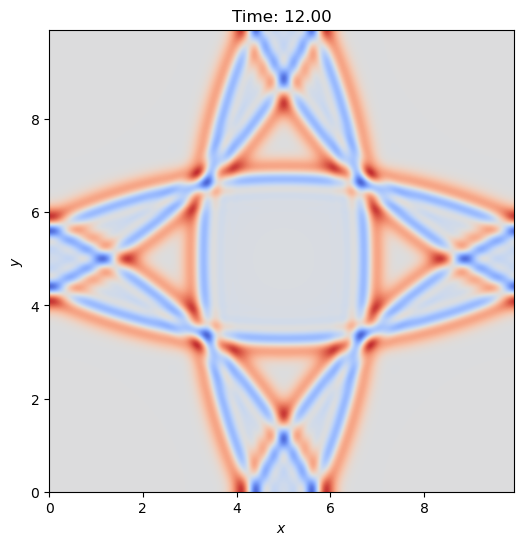

In [3]:
fig, ax = plt.subplots(figsize=(6,6))

def animate(i):
    """
    Animation function that updates the plot at each time step.
    
    Args:
        i (int): The current frame number (time step).
    """
    
    ax.clear()
    

    ax.set_title(f'Time: {t_list[i]:.2f}')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    

    im = ax.imshow(u_list[i].T, cmap='coolwarm', aspect='auto',
                   extent=[x.min(), x.max(), y.min(), y.max()],
                   origin='lower', interpolation='bicubic')
    
    return im,


ani = FuncAnimation(fig, animate, frames=len(u_list), blit=True)

ani.save('wave_animation.gif', writer='imagemagick', fps=10)

plt.show()